In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

In [1]:
result_dir = '../results/FP_Truthful_Oracle_sigmoids_cucb_est_click_impr/'

In [3]:
# Load the results
files_to_read = [file for file in os.listdir(result_dir) if file.endswith('.csv')]

In [4]:
results = pd.concat([pd.read_csv(result_dir + file) for file in files_to_read if file.startswith('agent_stats')])

In [5]:
# Prima raggruppo per Run e Iteration per avere il dato aggregato per ogni iterazione
grouped_results_run_iter = results.groupby(['Run', 'Iteration']) \
    .agg({'clicks': 'sum', 'impressions': 'sum', 'true_clicks':'sum'}) \
    .reset_index()

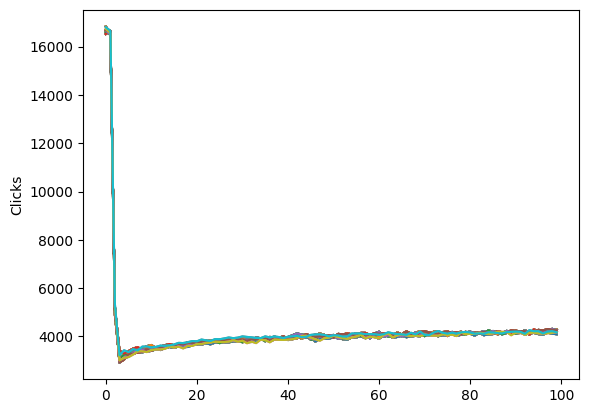

In [6]:
runs = grouped_results_run_iter['Run'].unique()
for run in runs:
    curr_run = grouped_results_run_iter[grouped_results_run_iter['Run'] == run]
    plt.plot(curr_run['Iteration'].to_numpy(), curr_run['clicks'].to_numpy(), label=f'Run {run}')
plt.ylabel('Clicks')
plt.show()

In [7]:
grouped_results_iter = grouped_results_run_iter.groupby('Iteration').mean().reset_index()

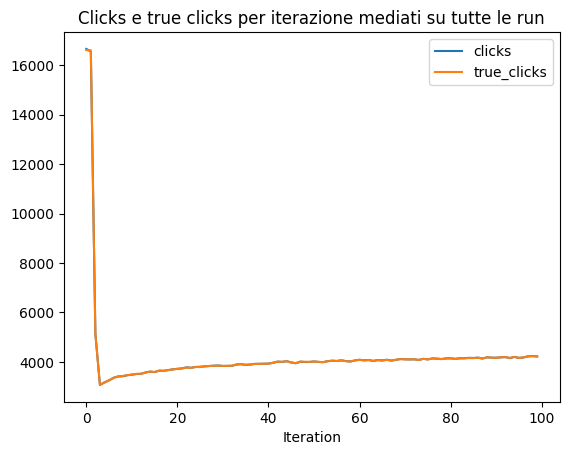

In [8]:
grouped_results_iter.plot(x='Iteration', y=['clicks', 'true_clicks'], title='Clicks e true clicks per iterazione mediati su tutte le run')
plt.show()

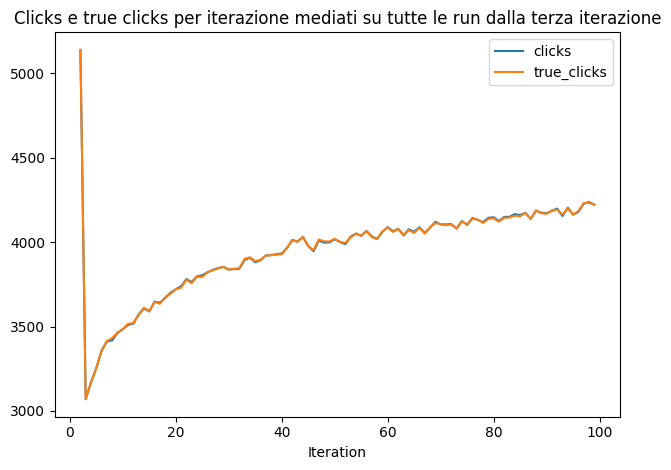

In [9]:
grouped_results_iter[grouped_results_iter['Iteration']>1].plot(x='Iteration', y=['clicks', 'true_clicks'], title='Clicks e true clicks per iterazione mediati su tutte le run dalla terza iterazione')
plt.tight_layout()
plt.show()

In [10]:
grouped_results_iter['ctr'] = grouped_results_iter['clicks'] / grouped_results_iter['impressions']
grouped_results_iter['true_ctr'] = grouped_results_iter['true_clicks'] / grouped_results_iter['impressions']

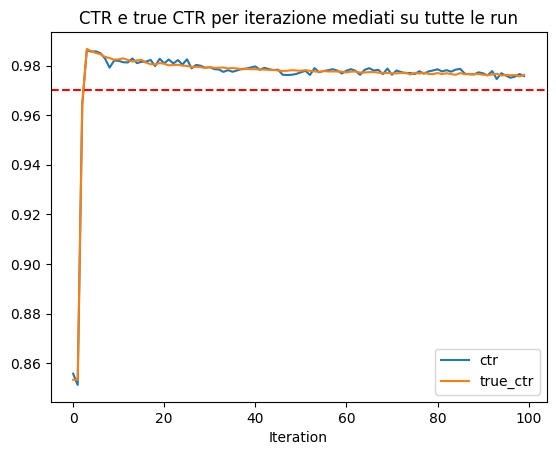

In [11]:
grouped_results_iter.plot(x='Iteration', y=['ctr', 'true_ctr'], title='CTR e true CTR per iterazione mediati su tutte le run')
plt.axhline(y=0.97, color='r', linestyle='--')
plt.show()

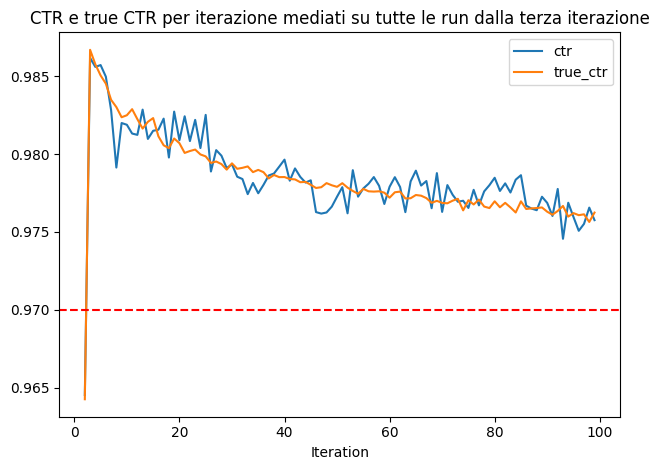

In [12]:
grouped_results_iter[grouped_results_iter['Iteration']>1].plot(x='Iteration', y=['ctr', 'true_ctr'], title='CTR e true CTR per iterazione mediati su tutte le run dalla terza iterazione')
plt.axhline(y=0.97, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [13]:
grouped_results_iter.to_csv(f"{result_dir}grouped_results_iter.csv", index=False)

## Calcolo il numero di click ottimo che si dovrebbe raggiungere

In [123]:
import numpy as np
from ortools.linear_solver import pywraplp

In [124]:
def get_data(
        df: pd.DataFrame,
):
    # Estraggo i dati dal dataframe
    n = df.shape[0]
    clicks = df['clicks'].values
    impressions = df['impressions'].values
    spent = df['spent'].values
    return n, clicks, impressions, spent

In [125]:
def solver(
        df: pd.DataFrame,
        n: int,
        clicks: np.ndarray = None,
        impressions: np.ndarray = None,
        spent: np.ndarray = None,
        cpc: np.ndarray = None,
        soglia_spent: float = None,
        soglia_clicks: float = None,
        soglia_cpc: float = None,
        soglia_ctr: float = None,
        soglia_num_publisher: int = None,
):
    # Inizializzo il solver
    solver = pywraplp.Solver.CreateSolver('SCIP')
    # Definisco le variabili
    x = [solver.BoolVar(f'x{i}') for i in range(n)]
    x_np = np.array(x)
    # Funzione obiettivo
    solver.Maximize(np.dot(clicks, x_np))
    if soglia_clicks is not None:
        # Vincolo Clicks
        solver.Add(np.dot(clicks, x_np) >= soglia_clicks)
    if soglia_spent is not None:
        # Vincolo Spesa
        solver.Add(np.dot(spent, x_np) <= soglia_spent)
    if soglia_cpc is not None:
        # Vincolo CPC
        solver.Add(np.dot(cpc, x_np) <= soglia_cpc)
    if soglia_ctr is not None:
        # Vincolo CTR
        solver.Add(np.dot(clicks, x_np) >= soglia_ctr * np.dot(impressions, x_np))
    if soglia_num_publisher is not None:
        # Vincolo Numero Publisher
        solver.Add(sum(x_np) <= soglia_num_publisher)
    # Risolvo il problema
    status = solver.Solve()
    results = pd.DataFrame(columns=df.columns)
    # Output dei risultati
    if status == pywraplp.Solver.OPTIMAL:
        for i in range(n):
            if x[i].solution_value() == 1:
                if results.empty:
                    results = df.iloc[[i]]
                else:
                    results = pd.concat([results, df.iloc[[i]]])
        print("Knapsack Solver: Soluzione ottimale trovata!")
        print(f"Valore obiettivo = {round(solver.Objective().Value(), 3)}")
        impressions_sum = results['impressions'].sum()
        if impressions_sum != 0:
            print(f"CTR = {round(results['clicks'].sum() / impressions_sum * 100, 3)}%")
        else:
            print(f"CTR = {0}%")
    else:
        print("Knapsack Solver: Non è stata trovata una soluzione ottimale.")
        # Return empty dataframe
        return pd.DataFrame()
    return results

### Carico i dati medi su click e impression di tutti i publisher

In [126]:
mean_results = pd.read_csv('../results/FP_Truthful_Oracle_sigmoids_1run1pub/mean_results.csv')

In [170]:
pub_to_look = results[results['Iteration']==0]['publisher'].unique()

In [171]:
mean_stats = mean_results[mean_results['publisher'].isin(pub_to_look)]

In [172]:
n, clicks, impressions, spent = get_data(mean_stats)

In [173]:
soglia_ctr = 0.97
results = solver(
    mean_stats,
    n,
    clicks=clicks,
    impressions=impressions,
    soglia_ctr=soglia_ctr,
)

Knapsack Solver: Soluzione ottimale trovata!
Valore obiettivo = 4312.86
CTR = 97.001%


In [174]:
opt_ctr = results['clicks'].sum() / results['impressions'].sum()
opt_clicks = results['clicks'].sum()
print(f"CTR ottimale = {opt_ctr}")
print(f"Clicks ottimali = {opt_clicks}")

CTR ottimale = 0.970008164256749
Clicks ottimali = 4312.86


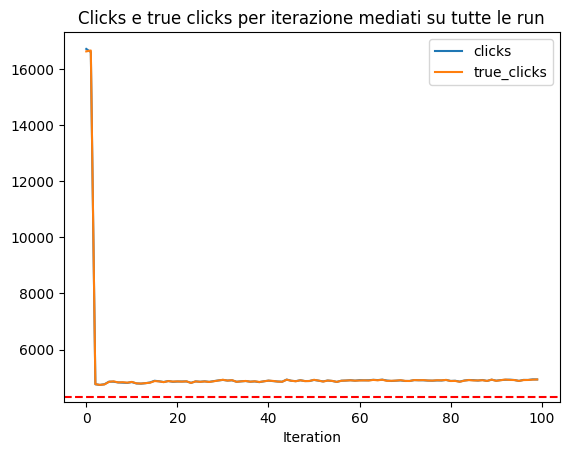

In [175]:
grouped_results_iter.plot(x='Iteration', y=['clicks', 'true_clicks'], title='Clicks e true clicks per iterazione mediati su tutte le run')
plt.axhline(y=opt_clicks, color='r', linestyle='--')
plt.show()

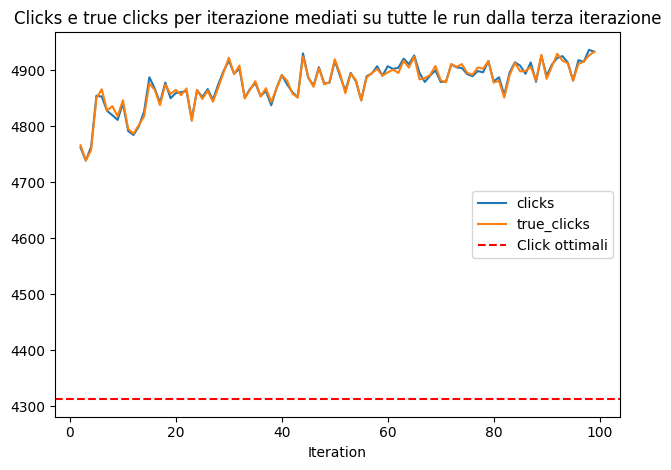

In [176]:
grouped_results_iter[grouped_results_iter['Iteration']>1].plot(x='Iteration', y=['clicks', 'true_clicks'], title='Clicks e true clicks per iterazione mediati su tutte le run dalla terza iterazione')
plt.axhline(y=opt_clicks, color='r', linestyle='--', label='Click ottimali')
plt.legend()
plt.tight_layout()
plt.show()